# Intro
The main goal for this project is to create and train a model capable of:
- Forecast a company behaviour in the stock exchange market for the following month from today
- Help to determine when is a good day to buy or sell attending to the forecast

To achive this, we will use:
- RNN/LSTM
- Stock Exchange real data for the given company
- Some technical analysis metrics (added as synthetic data)


# Imports

In [ ]:
# YFINANCE (Yahoo! Finance's) will help us to download market data
try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

In [ ]:
# PANDAS TA will allow us to generate technical analysis data as columns
try:
    import pandas_ta as ta
except:
    !pip install pandas_ta
    import pandas_ta as ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=ba6e28504abaea6edd6d3f69c1a47fe031ce1caa0ebc1b8ae74e473714f156cf
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
# Some more libraries we will be using
import os
import pandas    as pd
import pandas_ta as ta
import numpy     as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Libraries needed to scale our data
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Libraries needed to create and train our model
import tensorflow

from tensorflow.keras.models    import Sequential
from tensorflow.keras.layers    import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Gettin data from stock market
To download market data we will be using YFinance.

## Defining Variables

Since we need to create our own dataset to train our model, we will be defining some variables to make our code more flexible.

In [ ]:
ticker = 'FER.MC'   # company code in the market
                    # FER = Ferrovial, S.A.,
                    # MC = Code for 'Madrid Stock Exchange'
period = '7y'   # (seven years) Get data for the last seven years from today
interval = '1d' # (one day) One row per day

## Downloading the Data

In [ ]:
# Download market data for the given company during last period from today
# at the given interval
df = yf.download(tickers = ticker,
                 period = period,
                 interval = interval)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-22,29.719999,29.910000,29.60,29.719999,29.719999,670542
2023-09-25,29.660000,29.780001,29.40,29.600000,29.600000,768630
2023-09-26,29.320000,29.580000,29.27,29.459999,29.459999,134589


Downloaded data is composed by six columns:
*   Open.   Price at opening time
*   High.   Highest price during the interval
*   Low.    Lowest price during the interval
*   Close.  Price at closing time
*   Adj Close.  Closing price after adjusting for corporate events (dividends, stock splits, or mergers)
*   Volumen.    Amount of shares bought or sold



In [ ]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1793 entries, 2016-09-26 to 2023-09-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1793 non-null   float64
 1   High       1793 non-null   float64
 2   Low        1793 non-null   float64
 3   Close      1793 non-null   float64
 4   Adj Close  1793 non-null   float64
 5   Volume     1793 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 98.1 KB


In [ ]:
# Take a look at how the dataset is
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-09-26,18.215000,18.219999,17.975000,18.155001,14.664214,3961762
2016-09-27,18.230000,18.290001,18.059999,18.219999,14.716716,4105516
2016-09-28,18.344999,18.480000,18.254999,18.305000,14.785371,960961
2016-09-29,18.455000,18.799999,18.450001,18.680000,15.088267,3071327
2016-09-30,18.514999,19.070000,18.415001,18.950001,15.306354,2858057


In [ ]:
# check the length of the dataset
len(df)

1793

## Visualizing the Dataset

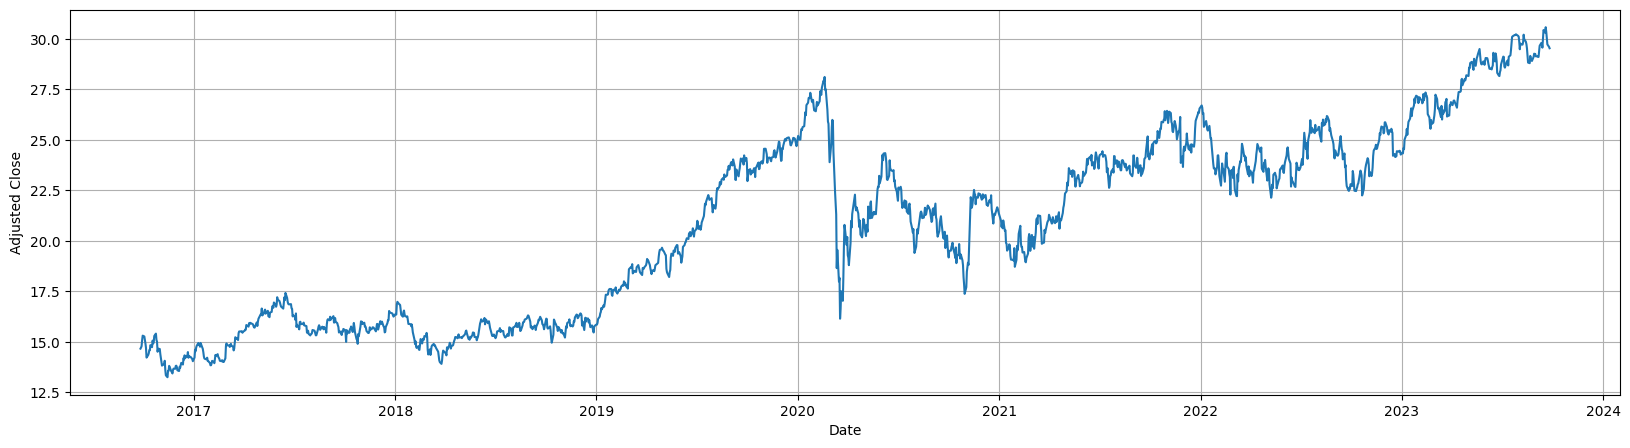

In [ ]:
# Plot Adjusted Close
plt.figure(figsize=(20, 5))
plt.plot(df['Adj Close'])
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.grid(True)
plt.show()

# Preprocessing Data

## Adding Technical Analysis Indicators

*   RSI -> Measures whether an asset is overbought or oversold based on its recent price history
*   EMA -> Used to predict the future value of an asset by weighting recent prices more heavily



In [ ]:
# Adding indicators
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMAF'] = ta.ema(df.Close, length=20)
df['EMAM'] = ta.ema(df.Close, length = 100)
df['EMAS'] = ta.ema(df.Close, length = 150)

In [ ]:
df = df.dropna()

## Reordering columns
Just to have target column as last column

In [ ]:
adj_close = df.pop('Adj Close')
df.insert(9, 'Adj Close', value = adj_close[:])

## Visualizing Dataset

In [ ]:
df.head()

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,Adj Close
Date,,,,,,,,,,
2017-04-26,19.295000,19.350000,19.075001,19.105000,2730904,59.447381,18.974768,18.080511,17.684833,15.786418
2017-04-27,19.155001,19.530001,19.059999,19.360001,1503488,65.045232,19.011457,18.105847,17.707021,15.997125
2017-04-28,19.405001,19.629999,19.320000,19.535000,2050212,68.266169,19.061318,18.134147,17.731233,16.141724
2017-05-02,19.650000,19.799999,19.514999,19.799999,2201810,72.393415,19.131669,18.167135,17.758634,16.360693
2017-05-03,19.790001,19.940001,19.635000,19.790001,1725620,72.014794,19.194367,18.199271,17.785539,16.352432


## Converting to a Numpy Array

In [ ]:
dataset = df.to_numpy()

# Splitting Data

## Train / Validation / Test splits

We will split our data in order to be able to run some tests and confirm how well the model is performing.

In [ ]:
training_data_len = int(len(dataset)*0.7)   # 70%
validation_data_len = int(len(dataset)*0.2) # 20%
testing_data_len = int(len(dataset)*0.1)    # 10%

In [ ]:
train_data = dataset[:training_data_len]
print(f'Training: {train_data.shape}')

val_data = dataset[training_data_len:training_data_len+validation_data_len]
print(f'Validation: {val_data.shape}')

test_data = dataset[-testing_data_len:]
print(f'Testing: {test_data.shape}')

Training: (1150, 10)
Validation: (328, 10)
Testing: (164, 10)


## Scale Data
We will scale the data using MinMaxScaler.

In [ ]:
# instantiate the scaler
scaler = MinMaxScaler()

In [ ]:
# train scaler and transform data
train_scaled_data = scaler.fit_transform(train_data)
val_scaled_data = scaler.transform(val_data)
test_scaled_data = scaler.transform(test_data)

In [ ]:
#printing random sample
train_scaled_data[0]

array([0.21506904, 0.21257064, 0.20972323, 0.20385956, 0.2259689 ,
       0.67069718, 0.1673331 , 0.04080201, 0.        , 0.13212883])

## Prepare Data for Prediction

In [ ]:
# this variable defines last N days taken into account for training the model
backcandles = 40

In [ ]:
x_train = []

for i in range(backcandles, len(train_scaled_data)):
    x_train.append(train_scaled_data[i-backcandles:i,:])

x_train = np.array(x_train)
print(f'Testing X: {x_train.shape}')

Testing X: (1110, 40, 10)


Now we have 1110 'packages' of 40 days. Each day have 10 columns of data.

# The Model

## Creating the Model

In [ ]:
model = Sequential()

# Input Layer
model.add(LSTM(units = 50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))

# Hidden Layers
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 50))
model.add(Dense(units = 25))

# Output Layer
model.add(Dense(x_train.shape[2]))

# Compiling model
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 50)            12200     
                                                                 
 lstm_7 (LSTM)               (None, 40, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                                 
Total params: 54135 (211.46 KB)
Trainable params: 54135 (211.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Early Stopper

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
early_stop = EarlyStopping(monitor='loss', patience=3)

## Training the Model

In [ ]:
# Do you want to train and save a new model? (True)
# Or load an existing Keras model (False)
train_model = True

In [ ]:
if train_model is True:
    model.fit(x=x_train,
            y=train_scaled_data[backcandles:],
            batch_size=1,
            callbacks=[early_stop],
            epochs = 20)

Epoch 1/20
1110/1110 [==============================] - 16s 10ms/step - loss: 0.0089
Epoch 2/20
1110/1110 [==============================] - 9s 8ms/step - loss: 0.0044
Epoch 3/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0031
Epoch 4/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0029
Epoch 5/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0027
Epoch 6/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0025
Epoch 7/20
1110/1110 [==============================] - 9s 8ms/step - loss: 0.0025
Epoch 8/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0024
Epoch 9/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0025
Epoch 10/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0023
Epoch 11/20
1110/1110 [==============================] - 10s 9ms/step - loss: 0.0023
Epoch 12/20
1110/1110 [==============================] - 9s 8ms/step - loss

## Saving the model

In [ ]:
if train_model is True:
    timestamp = str(datetime.now().timestamp())
    model.save('trading_model'+timestamp+'.keras')

## Loading Model

In [ ]:
if train_model is False:
    model = tensorflow.keras.models.load_model('trading_model1695547716.543292.keras')

# Performance Analisys

## On Validation Data
Prepare VALIDATION data for prediction

In [ ]:
x_val = []

for i in range(backcandles, len(val_scaled_data)):
    x_val.append(val_scaled_data[i-backcandles:i,:])

x_val = np.array(x_val)
print(f'Testing X: {x_val.shape}')

Testing X: (288, 40, 10)


Now we have 288 'packages' of 40 days and 10 columns.

In [ ]:
# make predictions
val_predictions = model.predict(x_val)

9/9 [==============================] - 1s 5ms/step


In [ ]:
# convert to pandas dataframe (just for convenience)
df_val_pred = pd.DataFrame(val_scaled_data[backcandles:,-1])
df_val_pred['predicted'] = val_predictions[:,-1]
df_val_pred.columns = ['Real', 'Predicted']

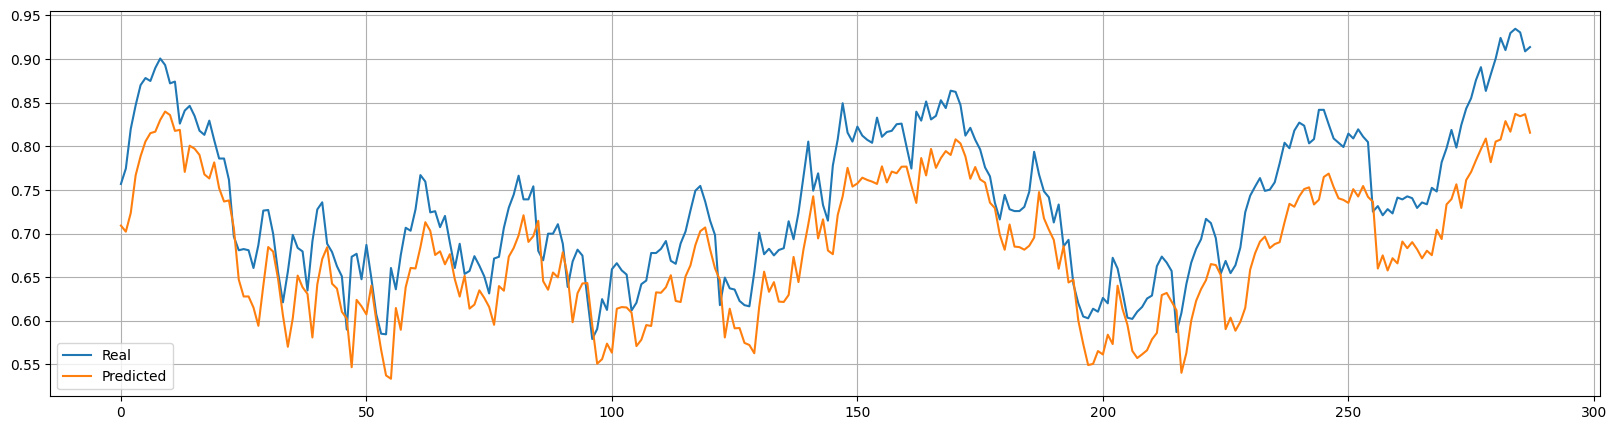

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_val_pred['Real'])
plt.plot(df_val_pred['Predicted'])

plt.legend(['Real', 'Predicted'])
plt.grid(True)

plt.show()

As you can observe, predictions looks good in general, however they show up some offset in both axis, X(time) and y(price).

Let's try to fix price adjusting with a mean value, and time shifting rows.

Since we try to predict one month in the future, let's use the mean only for a few days.

In [ ]:
n_days = 10

In [ ]:
# calculating mean difference for real vs. predicted price
df_val_pred['diff'] = df_val_pred['Real'] - df_val_pred['Predicted']
mean = df_val_pred['diff'][:n_days].mean()

# create a new column with price readjusted
df_val_pred['adj'] = df_val_pred['Predicted'] + df_val_pred['diff'].mean()

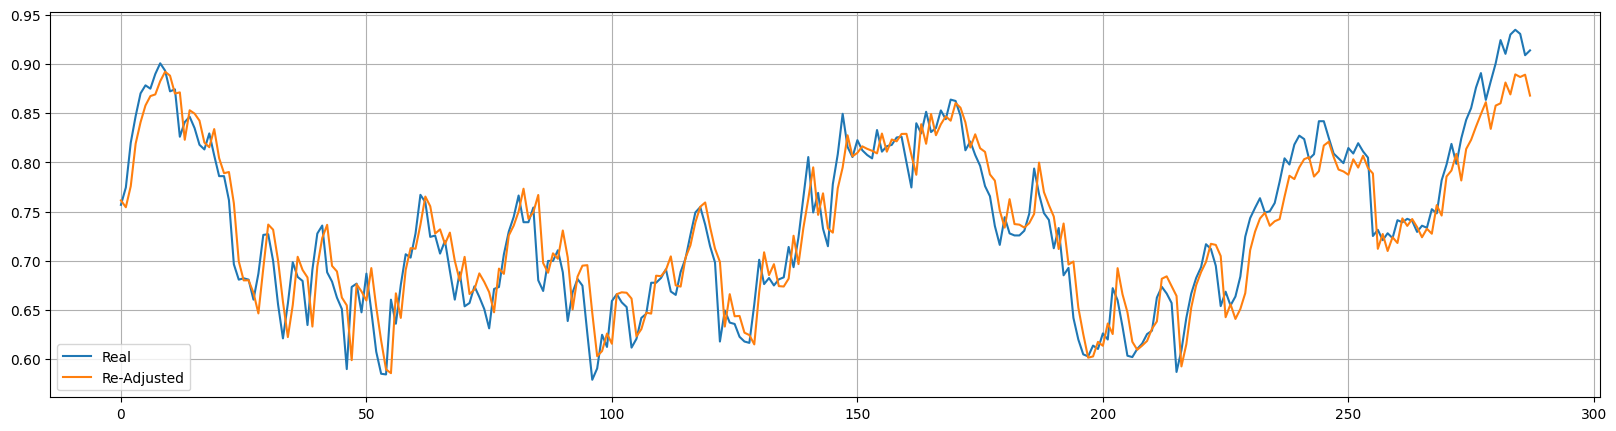

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_val_pred['Real'])
plt.plot(df_val_pred['adj'])

plt.legend(['Real', 'Re-Adjusted'])
plt.grid(True)

plt.show()

Now it is looking better on Y axis. Let's re-adjust the X axis.

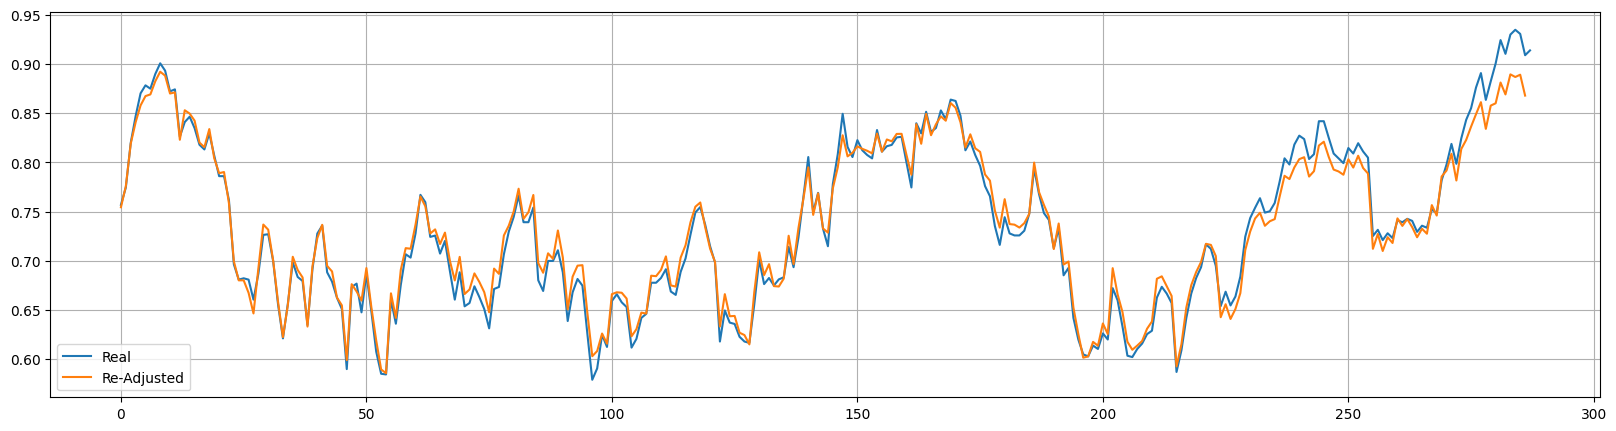

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_val_pred['Real'])
plt.plot(df_val_pred['adj'].shift(-1))

plt.legend(['Real', 'Re-Adjusted'])
plt.grid(True)

plt.show()

## On Testing Data
Let's do the same on data that our model has never 'seen' before.

In [ ]:
test_scaled_data.shape

(164, 10)

In [ ]:
x_test = []

for i in range(backcandles, len(test_scaled_data)):
    x_test.append(test_scaled_data[i-backcandles:i,:])

x_test = np.array(x_test)
print(f'Testing X: {x_test.shape}')

Testing X: (124, 40, 10)


In [ ]:
test_scaled_data[backcandles:,-1].shape

(124,)

In [ ]:
# make predictions
predictions_test = model.predict(x_test)

4/4 [==============================] - 1s 6ms/step


In [ ]:
# convert to pandas dataframe (just for convenience)
df_test_pred = pd.DataFrame(test_scaled_data[backcandles:,-1])
df_test_pred['predicted'] = predictions_test[:,-1]
df_test_pred.columns = ['Real', 'Predicted']

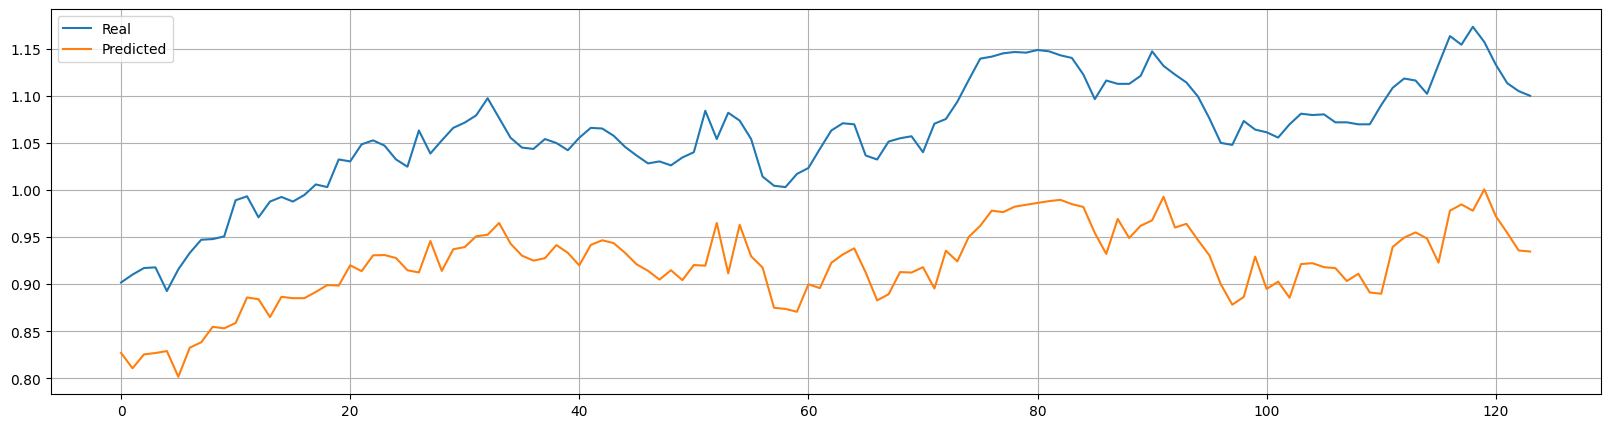

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_test_pred['Real'])
plt.plot(df_test_pred['Predicted'])

plt.legend(['Real', 'Predicted'])
plt.grid(True)

plt.show()

In [ ]:
# re-adjusting price (Y axis)
df_test_pred['diff'] = df_test_pred['Real'] - df_test_pred['Predicted']
mean = df_test_pred['diff'][:n_days].mean()
df_test_pred['adj'] = df_test_pred['Predicted'] + mean

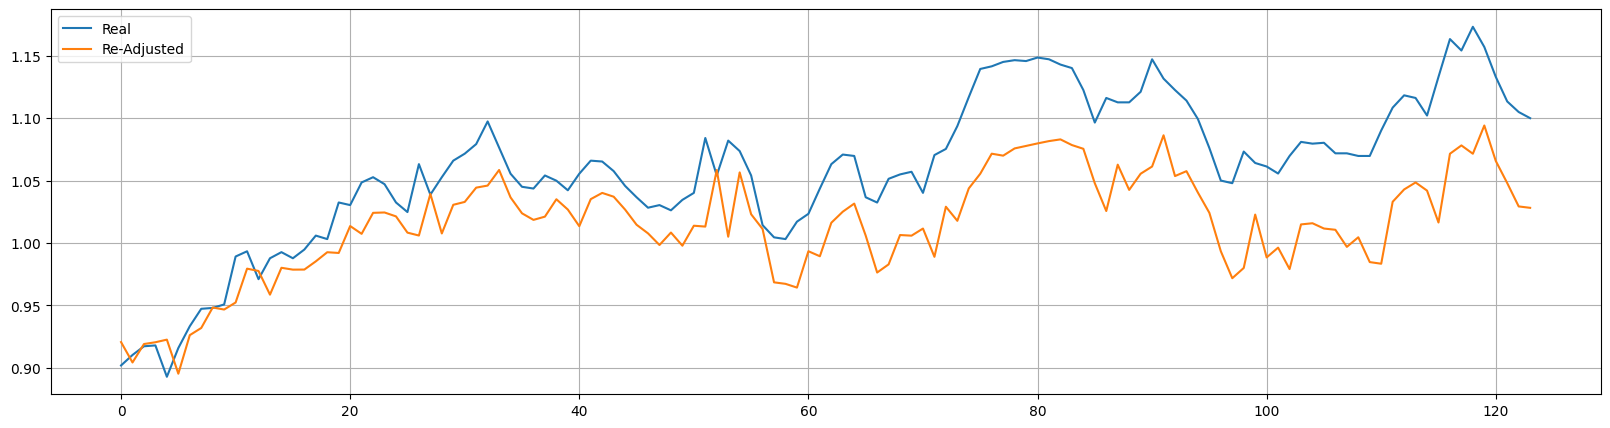

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_test_pred['Real'])
plt.plot(df_test_pred['adj'])

plt.legend(['Real', 'Re-Adjusted'])
plt.grid(True)

plt.show()

Readjust time and plot again

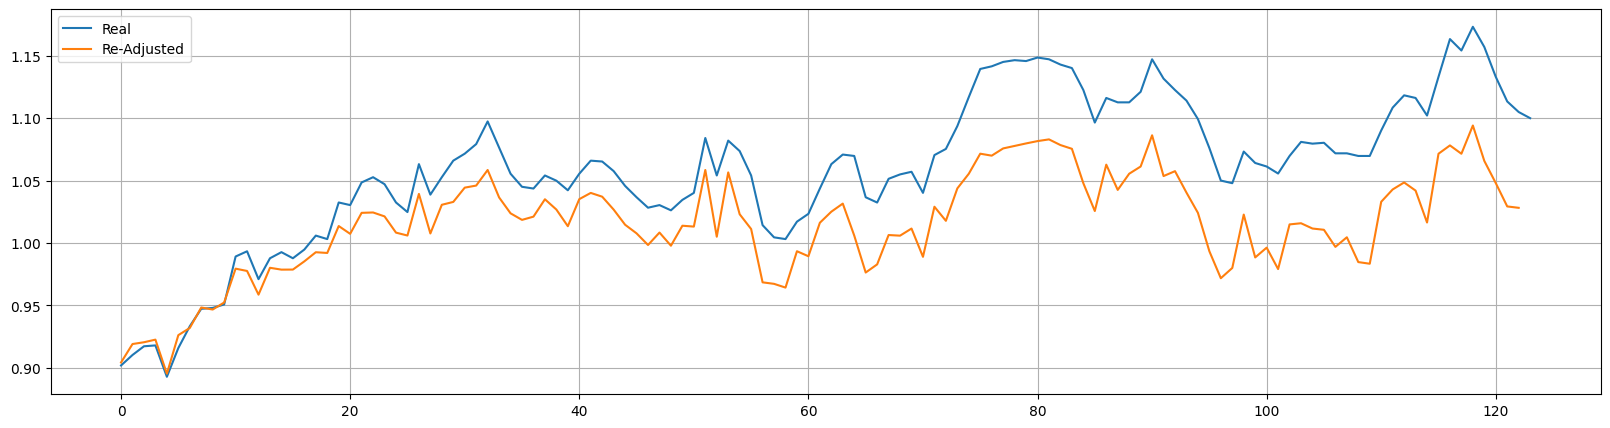

In [ ]:
# plotting prediction vs. real data
plt.figure(figsize=(20, 5))

plt.plot(df_test_pred['Real'])
plt.plot(df_test_pred['adj'].shift(-1)) # this line readjust X axis (time)

plt.legend(['Real', 'Re-Adjusted'])
plt.grid(True)

plt.show()

# Real Data + Prediction

Let's plot the whole thing, all real data + prediction for next month

## Predicting Next Month
From last N rows of real data (40 in our case, defined in 'backcandles' variable), let's forecast 20 days in the future (one month aprox.)

In [ ]:
x_test.shape

(124, 40, 10)

In [ ]:
forecast_data = x_test[-1:,:,:] # take last package which already contains last 40 rows of real data
forecast_data.shape

(1, 40, 10)

In [ ]:
future_days = 20
forecast_preds = []
for day in range(future_days):
    #predict
    forecast = model.predict(forecast_data) #make prediction
    forecast_preds.append(forecast) #store pred.

    #update forecast data
    forecast_data = forecast_data[:,1:,:] #drop oldest day (first)
    forecast_data = np.insert(forecast_data, backcandles-1, forecast, axis=1) #append last prediction as newest day (last)

1/1 [==============================] - 0s 22ms/step


Our predictions are now 20 'packages', each of 1 day and 10 columns

In [ ]:
np.array(forecast_preds).shape

(20, 1, 10)

In [ ]:
# printing last column of each day
# (last column is 'predicted price')
np.array(forecast_preds)[:,:,-1]

array([[0.9347472 ],
       [0.91527   ],
       [0.8897204 ],
       [0.86577165],
       [0.8417368 ],
       [0.8175634 ],
       [0.79291385],
       [0.76753664],
       [0.7412115 ],
       [0.7137444 ],
       [0.68498063],
       [0.65482724],
       [0.62329465],
       [0.59054565],
       [0.55695236],
       [0.5231387 ],
       [0.4899811 ],
       [0.45855314],
       [0.43000448],
       [0.40538412]], dtype=float32)

In [ ]:
# reshaping to 2D array to be able to convert to Pandas Dataframe in following section
forecast_preds = np.array(forecast_preds)
forecast_preds = forecast_preds.reshape((20,10))
forecast_preds.shape

(20, 10)

## Prepare Real Data

In [ ]:
# preparing unscaled real data to be plotted
real_unscaled = df.copy()
real_unscaled = pd.DataFrame(real_unscaled)
real_unscaled = real_unscaled.reset_index(drop=True)
real_unscaled

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,Adj Close
0,19.295000,19.350000,19.075001,19.105000,2730904,59.447381,18.974768,18.080511,17.684833,15.786418
1,19.155001,19.530001,19.059999,19.360001,1503488,65.045232,19.011457,18.105847,17.707021,15.997125
2,19.405001,19.629999,19.320000,19.535000,2050212,68.266169,19.061318,18.134147,17.731233,16.141724
3,19.650000,19.799999,19.514999,19.799999,2201810,72.393415,19.131669,18.167135,17.758634,16.360693
4,19.790001,19.940001,19.635000,19.790001,1725620,72.014794,19.194367,18.199271,17.785539,16.352432
...,...,...,...,...,...,...,...,...,...,...
1639,30.500000,30.670000,30.299999,30.340000,681046,62.951094,29.772721,29.082962,28.597067,30.340000
1640,30.150000,30.270000,29.799999,30.000000,960470,55.617501,29.794367,29.101121,28.615649,30.000000
1641,29.719999,29.910000,29.600000,29.719999,670542,50.433384,29.787284,29.113376,28.630276,29.719999
1642,29.660000,29.780001,29.400000,29.600000,768630,48.363424,29.769448,29.123012,28.643120,29.600000


## Un-Scale Prediction Data

In [ ]:
# unscale predicted data and convert to Pandas dataframe
df_fore_preds = scaler.inverse_transform(forecast_preds)
df_fore_preds = pd.DataFrame(df_fore_preds)
df_fore_preds

,0,1,2,3,4,5,6,7,8,9
0,28.984262,29.390593,28.578512,29.013653,1980899.750,51.131763,29.453537,28.296490,27.441048,27.182798
1,28.718826,29.124643,28.321747,28.732964,2032348.125,51.193024,29.199413,28.094479,27.263933,26.906240
2,28.366865,28.772520,27.959494,28.366222,2104546.500,49.896027,28.957743,27.918867,27.124811,26.543463
3,28.044804,28.438194,27.617945,28.026972,2184326.500,48.915455,28.690844,27.733553,26.979843,26.203415
4,27.719311,28.105417,27.276930,27.689201,2256654.000,47.869625,28.423996,27.560444,26.843687,25.862143
5,27.386299,27.769346,26.932846,27.346838,2319687.000,46.800671,28.152468,27.392141,26.712643,25.518906
6,27.039513,27.424431,26.579624,26.992620,2373098.250,45.688934,27.874975,27.226389,26.586075,25.168907
7,26.674892,27.066366,26.212345,26.621607,2417742.750,44.527424,27.589497,27.061207,26.463236,24.808575
8,26.289246,26.691500,25.826754,26.230009,2454551.500,43.311134,27.294153,26.895382,26.343531,24.434784
9,25.880009,26.296730,25.419228,25.814907,2484360.250,42.038506,26.987202,26.728077,26.226332,24.044779


In [ ]:
# set columns names (just for convenience)
df_fore_preds.columns = real_unscaled.columns

# set right index so it is plotted right after real data
new_index = len(real_unscaled)
df_fore_preds.index = df_fore_preds.index + new_index
df_fore_preds

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,Adj Close
1644,28.984262,29.390593,28.578512,29.013653,1980899.750,51.131763,29.453537,28.296490,27.441048,27.182798
1645,28.718826,29.124643,28.321747,28.732964,2032348.125,51.193024,29.199413,28.094479,27.263933,26.906240
1646,28.366865,28.772520,27.959494,28.366222,2104546.500,49.896027,28.957743,27.918867,27.124811,26.543463
1647,28.044804,28.438194,27.617945,28.026972,2184326.500,48.915455,28.690844,27.733553,26.979843,26.203415
1648,27.719311,28.105417,27.276930,27.689201,2256654.000,47.869625,28.423996,27.560444,26.843687,25.862143
1649,27.386299,27.769346,26.932846,27.346838,2319687.000,46.800671,28.152468,27.392141,26.712643,25.518906
1650,27.039513,27.424431,26.579624,26.992620,2373098.250,45.688934,27.874975,27.226389,26.586075,25.168907
1651,26.674892,27.066366,26.212345,26.621607,2417742.750,44.527424,27.589497,27.061207,26.463236,24.808575
1652,26.289246,26.691500,25.826754,26.230009,2454551.500,43.311134,27.294153,26.895382,26.343531,24.434784
1653,25.880009,26.296730,25.419228,25.814907,2484360.250,42.038506,26.987202,26.728077,26.226332,24.044779


## Plot All Together

In [ ]:
# Little feature (OPTIONAL) to zoom in on last days
# 100 = Shows 100% available data
# 50 = Shows last 50% of last data
# 20 = Shows last 20% of last data
# etc...
# Prediction is always plotted fully
zoom_in = 8

if not (zoom_in > 0 and zoom_in <= 100): zoom_in = 1

zoomed = int((len(real_unscaled) * zoom_in) / 100)
print(zoomed)

131


In [ ]:
# calculate difference between last real price and first prediction, so we can adjust both plots
diff = real_unscaled.iloc[(-1)]['Adj Close'] - df_fore_preds.iloc[(0)]['Adj Close']

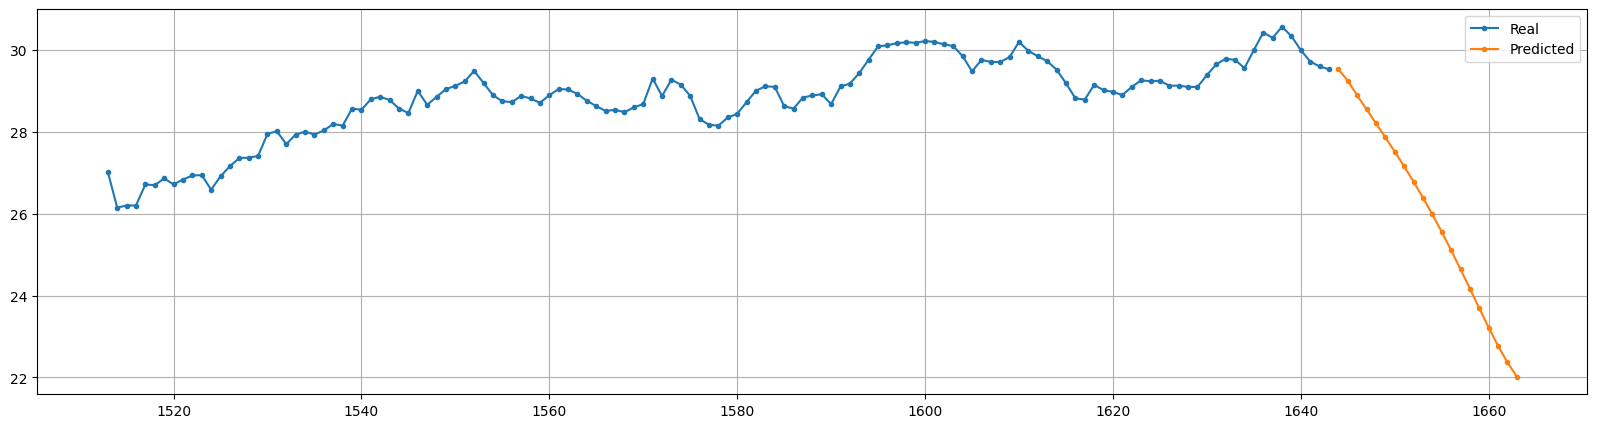

In [ ]:
# plotting real data AND prediction for next 20 days
plt.figure(figsize=(20, 5))

plt.plot(real_unscaled['Adj Close'][-zoomed:], marker='.')
plt.plot(df_fore_preds['Adj Close']+diff, marker='.')

plt.legend(['Real', 'Predicted'])
plt.grid(True)

plt.show()

# Conclusions

*  One really important thing we can appreciate is that predictions looks like a trend, and not like a real trading chart.
*  This could be caused because of the more in the future our prediction is, the more based on predictions is, so the more error we are facing.
*   However, there should be some other reason because, even when the previous point is probably true, for the first predictions, the data provided is mostly real data.



# Possible Issues


*   are we overfitting the model?
*   

